In [26]:
import numpy as np
import pandas as pd
import one_hot

def SigmoidActivationFunction(weightedInput):
    return 1/(1 + np.exp(-weightedInput))

def SigmoidActivationFunctionDerivative(activated):
    return activated * (1 - activated) 

class Layer:
    def __init__(self,inputNodes,outputNodes) -> None:

        self.inputNodes = inputNodes
        self.outputNodes = outputNodes
        """
        WEIGHTS
        tworzy 2-wymiarową listę z wartościami wag 
        Przykładowo gdy warstwa ma 2 wejścia i 3 wyjścia
        [w11   w21   w31]
        [w12   w22   w32]
        [w13   w23   w33]
        Z wartości pierwszej kolumny obliczana jest wartość wyjściowa dla 1 wyjścia
        Z wartości drugiej kolmny obliczana jest wartość wyjściowa 2 wyjścia
        BIAS_VALUES
        tworzy 1-wymiarową listę o wymiarze ilości wyjść dla warstwy
        Do wartości wyliczonej z popagacji do przodu do wyjścia dodawana jest wartość bias
        3 wyjścia
        [bias1 bias2 bias3]
        """
        self.weights = np.random.rand(inputNodes,outputNodes) - 0.5
        self.bias_values = np.random.rand(1, outputNodes) - 0.5

    """
    Gdy mamy doczynienia z pierwszą warstwą sieci 2 cechy wejścia i 2 klasy wyścia(layer(2,2))
    funkcja przelicza cechy*wagi i zwraca wartości wyjściowych neurownów 
    Gdy wsadzimy w funkcję listę [n_próbek, n_cech] to zwraca [n_próbek, n_neuronów_wyjściowych]
    dla 5 próbek i sieci (2,2) [5,2]
    X : tablica [n_próbek, n_cech]
    -> [n_próbek, n_outputNodes]
    """
    def forward_propagation(self,X):
        self.input = X
        output_values = np.dot(X,self.weights) + self.bias_values
        self.z = output_values
        activation_values = SigmoidActivationFunction(output_values)
        self.a = activation_values
        return activation_values

    """
    X: tablica [n_próbek,n_cech]
    -> tablica [n_próbek]
    """
    def predict(self,X):
        activation_values = self.forward_propagation(X)

        predictions = np.argmax(activation_values,axis=1)

        return predictions

    def NodeCost(self,outputActivation,expectedOutput):
        error = (outputActivation - expectedOutput)**2
        return 0.5*error

class NeuralNetwork:
    def __init__(self,layerSizes,epoch,eta,minibatch_size) -> None:
        self.layers = [None]*(len(layerSizes)-1)
        for i in range(len(self.layers)):
            self.layers[i] = Layer(layerSizes[i],layerSizes[i+1])

        self.l2 = 0.
        self.epoch = epoch
        self.eta = eta
        self.errors = []
        self.minibatch_size = minibatch_size

    def network_forward_propagation(self,X):
        for layer in self.layers:
            X = layer.forward_propagation(X)

        return X

    def network_predict(self,X):
        activation_values = self.network_forward_propagation(X)

        predictions = np.argmax(activation_values,axis = 1)

        return predictions
    
    def network_loss(self,X,y, activation_values):

        outputLayer = self.layers[len(self.layers)-1]
        total_cost = 0
        cost_single_data = 0

        for xi, target in zip(activation_values,y):
            for i in range(len(activation_values[0])):
                cost_single_data += outputLayer.NodeCost(xi[i],target[i]) 

            total_cost += cost_single_data
            cost_single_data = 0

        return total_cost / len(X)

    def UpdateAllGradients(self,y, y_predict):
        delta = (y_predict - y)
        m = delta.shape[0]

        for i in range(-1, -len(self.layers) - 1, -1):
            layer = self.layers[i]
            dWeights  =  np.dot(layer.input.T, delta)
            layer.weights -= dWeights/ m * self.eta
            layer.bias_values -= np.sum(delta) / m * self.eta
            delta = np.dot(delta, layer.weights.T) * SigmoidActivationFunctionDerivative(layer.input)

    def learn(self,X,y):
        y = one_hot._onehot(y,self.layers[len(self.layers)-1].outputNodes)
        for i in range(self.epoch):
            y_predicted = activation_values = self.network_forward_propagation(X)
            self.UpdateAllGradients(y, y_predicted)
            self.errors.append(self.network_loss(X,y, activation_values))
            if i % 10 == 0:
                print(f"Epoch {i} error {self.errors[-1]}")

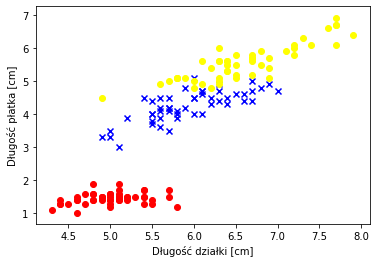

In [9]:
import matplotlib.pyplot as plt 

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)

y1 =  df.iloc[0:150,4].values
y = np.where(y1[100:150] == 'Iris-virginica',2,0)
y2 = np.where(y1[50:100] == 'Iris-versicolor',1,0)
y3 = np.where(y1[0:50] == 'Iris-setosa',0,1)
y_final = np.append(y,y2)
Y = np.append(y_final,y3)
X = df.iloc[0:150,[0,2]].values


plt.scatter(X[:50,0],X[:50,1],color = 'red', marker = 'o', label = 'Setosa')
plt.scatter(X[50:100,0],X[50:100,1],color = 'blue', marker = 'x', label = 'Versicolor')
plt.scatter(X[100:150,0],X[100:150,1],color = 'yellow', marker = 'o', label = 'Virginica')
plt.xlabel('Długość działki [cm]')
plt.ylabel('Długość płatka [cm]')
plt.show()

In [10]:
layers = [2, 4, 3]
network = NeuralNetwork(layers, 40000, 0.01, 10)
network.learn(X, Y)

Epoch 0 error 0.3919426327711844
Epoch 10 error 0.3826365945062815
Epoch 20 error 0.3747907266043131
Epoch 30 error 0.3681757773206711
Epoch 40 error 0.36258669321364984
Epoch 50 error 0.3578475869885514
Epoch 60 error 0.35381278155255796
Epoch 70 error 0.3503649850821933
Epoch 80 error 0.3474113679610882
Epoch 90 error 0.34487828131226306
Epoch 100 error 0.3427056210192698
Epoch 110 error 0.3408420126205459
Epoch 120 error 0.33924166457175325
Epoch 130 error 0.3378629898173346
Epoch 140 error 0.3366684374063649
Epoch 150 error 0.33562478466788886
Epoch 160 error 0.334703353074755
Epoch 170 error 0.3338799359912839
Epoch 180 error 0.3331344554365944
Epoch 190 error 0.3324504562083887
Epoch 200 error 0.3318145468325685
Epoch 210 error 0.3312158632558985
Epoch 220 error 0.3306455955958691
Epoch 230 error 0.33009659239117445
Epoch 240 error 0.3295630415143149
Epoch 250 error 0.32904021940368894
Epoch 260 error 0.32852429748828077
Epoch 270 error 0.32801219437514917
Epoch 280 error 0.32750

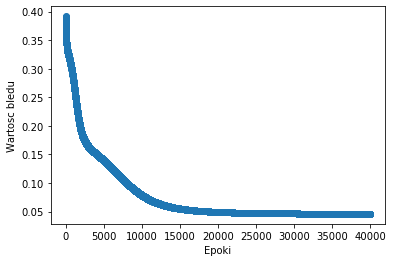

In [11]:
plt.plot(range(1,len(network.errors)+1),network.errors,marker = 'o')
plt.xlabel('Epoki')
plt.ylabel('Wartosc bledu')
plt.show()

In [13]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.network_predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

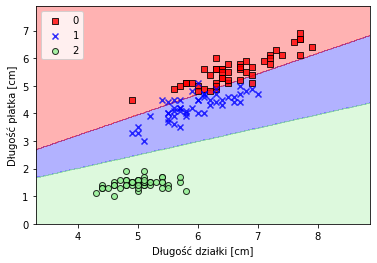

In [14]:
plot_decision_regions(X, Y, classifier=network)
plt.xlabel('Długość działki [cm]')
plt.ylabel('Długość płatka [cm]')
plt.legend(loc='upper left')
plt.show()

In [20]:
data = pd.read_csv('train.csv')
data = np.array(data)
np.random.shuffle(data)

data_train = data.T
Y = data_train[0]
X = data_train[1:].T
X = X / 255.

In [28]:
layers = [784, 10, 10]
network = NeuralNetwork(layers, 1000, 0.1, 10)
network.learn(X, Y)

Epoch 0 error 1.2087408813247391
Epoch 10 error 0.461207634402047
Epoch 20 error 0.45163286383458623
Epoch 30 error 0.4483537154796093
Epoch 40 error 0.4455117195015085
Epoch 50 error 0.4426599992749152
Epoch 60 error 0.43971280654866435
Epoch 70 error 0.43663888653591054
Epoch 80 error 0.4334255946903562
Epoch 90 error 0.43006994634118445
Epoch 100 error 0.4265738146940848
Epoch 110 error 0.4229412758717756
Epoch 120 error 0.4191777876831783
Epoch 130 error 0.4152904647235839
Epoch 140 error 0.41128860739203343
Epoch 150 error 0.4071839559816016
Epoch 160 error 0.40299048551791583
Epoch 170 error 0.39872379209082554
Epoch 180 error 0.3944002567745488
Epoch 190 error 0.3900361922342705
Epoch 200 error 0.3856471010452657
Epoch 210 error 0.38124708144696906
Epoch 220 error 0.3768483711765409
Epoch 230 error 0.37246103110438783
Epoch 240 error 0.3680928003553253
Epoch 250 error 0.36374916035425336
Epoch 260 error 0.359433611679252
Epoch 270 error 0.3551481152995554
Epoch 280 error 0.35089

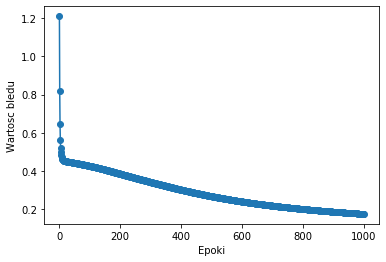

In [29]:
plt.plot(range(1,len(network.errors)+1),network.errors,marker = 'o')
plt.xlabel('Epoki')
plt.ylabel('Wartosc bledu')
plt.show()